This notebook will get a take a protein family of choice from UniProt, download the sequences with annotations such as domains, PDB codes and taxonomy and then cluster by similarity. 

The sequence space will be plotted and the most representative sequences will be taken from across the sequence space 

Finally the selected sequences will be analysed for solubility and expressebility in e coli 

Eventually this will be combined with automated analysis of the proteins in the lab to train a reinforcement learning network 

First you will need to go to uniprot, search for the interpro or pfam ID you are interested in. We will download 2 files, a Fasta file and a TSV file
for the fasta file just download the default option. for TSV follow below.
Select download, format: TSV and select the annotations you are interested in. I generally add taxnomic lineage, PDB, and domain [FT], ensure you also. Then generate URL for API. 

In [2]:
#get sequence data using uniprot api 
import requests

url = 'https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession%2Creviewed%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength%2Clineage%2Cxref_pdb%2Cft_domain&format=tsv&query=%28IPR001223%29+AND+%28reviewed%3Atrue%29' #enter your URL here
sequences = requests.get(url).text

Instead of using the API we can just download the TSV and move it to the directory you are running this notebook from. Then we will use mmseqs to clean the data create an all by all comparison, you will need to install mmseqs2 first. https://github.com/soedinglab/mmseqs2/wiki

In [3]:
# remove sequences with greater than 0.8 sequence identity
!mmseqs easy-cluster input.fasta clusterRes tmp --min-seq-id 0.8 #clusters sequences with 80% similarity

easy-cluster input.fasta clusterRes tmp --min-seq-id 0.8 

MMseqs Version:                     	15-6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask residues probability           	0

After cleaning the dataset we need to do an all by all comparison to cluster the sequences by similarity 

In [4]:
# perform all by all search on cleaned sequences
!mmseqs easy-search clusterRes_rep_seq.fasta clusterRes_rep_seq.fasta all_by_all.tsv /tmp --threads 8 

all_by_all.tsv exists and will be overwritten
easy-search clusterRes_rep_seq.fasta clusterRes_rep_seq.fasta all_by_all.tsv /tmp --threads 8 

MMseqs Version:                        	15-6f452
Substitution matrix                    	aa:blosum62.out,nucl:nucleotide.out
Add backtrace                          	false
Alignment mode                         	3
Alignment mode                         	0
Allow wrapped scoring                  	false
E-value threshold                      	0.001
Seq. id. threshold                     	0
Min alignment length                   	0
Seq. id. mode                          	0
Alternative alignments                 	0
Coverage threshold                     	0
Coverage mode                          	0
Max sequence length                    	65535
Compositional bias                     	1
Compositional bias                     	1
Max reject                             	2147483647
Max accept                             	2147483647
Include identical seq. id. 

Now we will use John's Cluster tools package to analyse the results of the all by all search

In [5]:
#first import the modules we need

from ClusterTools.cluster_stream import cluster_stream
from ClusterTools.cluster_progression import cluster_progression
#from ClusterTools.circle_plot import PlotCirclesBox2D
from ClusterTools.cluster_size_table import MakeTable
from ClusterTools.cluster_consensus import ParseClusters
import sys
sys.path.append("./ClusterTools/")  # replace with the actual path
import pandas as pd

The code below analyses how the cluster sizes vary by bitscore cutoff, other scoring metrics can be used by changing the score setting to a different column in the all_by_all.tsv file

In [6]:
cluster_stream('all_by_all.tsv',cutoffs=[100,200,300,400,500,600,700], score = 3, directory='cluster_stream_res')

---cutoff: 100
2 clusters with 126 sequences
5 single nodes added
0 unconnected nodes added
---cutoff: 200
4 clusters with 122 sequences
9 single nodes added
0 unconnected nodes added
---cutoff: 300
3 clusters with 116 sequences
15 single nodes added
0 unconnected nodes added
---cutoff: 400
4 clusters with 82 sequences
49 single nodes added
0 unconnected nodes added
---cutoff: 500
9 clusters with 35 sequences
96 single nodes added
0 unconnected nodes added
---cutoff: 600
5 clusters with 19 sequences
112 single nodes added
0 unconnected nodes added
---cutoff: 700
5 clusters with 16 sequences
115 single nodes added
0 unconnected nodes added
5373 
0.02s



['cluster_400.csv', 'cluster_600.csv', 'cluster_200.csv', 'cluster_700.csv', 'cluster_500.csv', 'cluster_100.csv', 'cluster_300.csv']


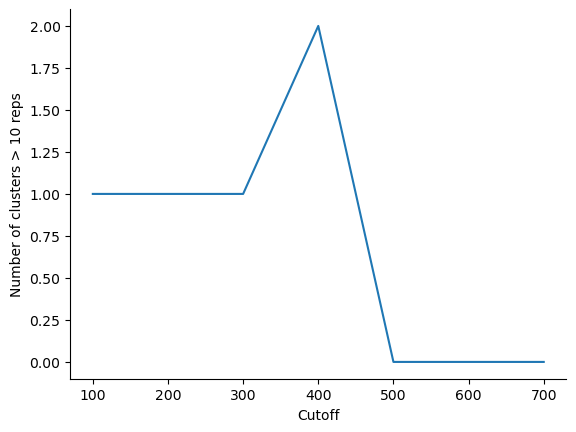

In [7]:
cluster_progression('cluster_stream_res', filter = 10)

the next function creates a table with the cluster IDs and the numbers of members. list files containing uniprot IDs of interest can be added as additional arguments to locate which cluster these proteins are in.

In [8]:
clusters = MakeTable('cluster_stream_res/cluster_400.csv', )
print(clusters)
clusters.to_csv('cluster_size_table.csv', index=False)

    cluster  rep_count
0         0         66
1         1         11
2         2          3
3         3          2
40       40          1
30       30          1
31       31          1
32       32          1
33       33          1
34       34          1
35       35          1
36       36          1
37       37          1
38       38          1
39       39          1
41       41          1
28       28          1
42       42          1
43       43          1
44       44          1
45       45          1
46       46          1
47       47          1
48       48          1
49       49          1
50       50          1
51       51          1
29       29          1
26       26          1
27       27          1
25       25          1
4         4          1
5         5          1
6         6          1
7         7          1
8         8          1
9         9          1
10       10          1
11       11          1
12       12          1
13       13          1
14       14          1
15       15

The next function, ParseClusters will create a zip file containing an Hmm and an alginment file for each cluster with the most representative sequence at the top

In [26]:
def clusters_to_string_list(clusters):
    # Filter clusters with at least 2 members
    filtered_clusters = clusters[clusters['rep_count'] >= 2]  # Assuming 'rep_count' contains the member count
    return filtered_clusters['cluster'].astype(str).tolist()

cluster_list = clusters_to_string_list(clusters)
print(cluster_list)


['0', '1', '2', '3']


In [27]:
#this cell isnt working 
ParseClusters(cluster_file='cluster_stream_res/cluster_400.csv', fasta_file= 'input_clean.fasta',target_clusters=cluster_list,zip_path='consensus_cutoff500.zip', id_index= 1)
print(f'Clusters collected: {clusters}') #debugging

# unzip the consensus to seperate folder
#import zipfile
#with zipfile.ZipFile('consensus_cutoff500.zip', 'r') as zip_ref:
    #zip_ref.extractall('consensus_cutoff500')

Extracted ID: A0A072UR65
Extracted ID: A0A1B1J8Z2
Extracted ID: A5FB63
Extracted ID: B6A876
Extracted ID: B6A879
Extracted ID: G1UH28
Extracted ID: G5EB30
Extracted ID: O35744
Extracted ID: O81862
Extracted ID: P0CB51
Extracted ID: P13656
Extracted ID: P19172
Extracted ID: P23472
Extracted ID: P29029
Extracted ID: P30922
Extracted ID: P36222
Extracted ID: P40953
Extracted ID: P40954
Extracted ID: P80036
Extracted ID: Q12889
Extracted ID: Q13231
Extracted ID: Q15782
Extracted ID: Q23997
Extracted ID: Q29411
Extracted ID: Q5AAH2
Extracted ID: Q5RBP6
Extracted ID: Q60557
Extracted ID: Q61362
Extracted ID: Q62010
Extracted ID: Q6RY07
Extracted ID: Q6TMG6
Extracted ID: Q7YS85
Extracted ID: Q873X9
Extracted ID: Q873Y0
Extracted ID: Q8I4R4
Extracted ID: Q8L5C6
Extracted ID: Q8MLZ7
Extracted ID: Q8MM24
Extracted ID: Q8SPQ0
Extracted ID: Q91XA9
Extracted ID: Q95M17
Extracted ID: Q9BWS9
Extracted ID: Q9BZP6
Extracted ID: Q9D7Q1
Extracted ID: Q9V3D4
Extracted ID: Q9W092
Extracted ID: Q9W303
Extra

The below cell takes clusters of varying bit score trhesholds from JOhn's SSN workflow and compiles representatives into an 'allcluster.fasta' master file

In [11]:
import pandas as pd
import subprocess
import os
from Bio import SeqIO
from tqdm import tqdm

In [12]:


def remove_non_amino_acids(seq):
    # List of non-amino acid characters to remove
    non_amino_acids = set(['X', 'B'])

    # Remove non-amino acid characters from the sequence
    return ''.join(aa for aa in seq if aa not in non_amino_acids)

def process_fasta(input_file, output_file):
    with open(input_file, 'r') as input_handle, open(output_file, 'w') as output_handle:
        for record in SeqIO.parse(input_handle, 'fasta'):
            # Remove non-amino acid characters from the sequence
            clean_seq = remove_non_amino_acids(record.seq)
            
            # Write the cleaned sequence to the output file
            output_handle.write(f'>{record.id}\n{clean_seq}\n')

if __name__ == "__main__":
    input_file = 'input.fasta'  # Replace with the path to your input FASTA file
    output_file = 'input_clean.fasta'  # Replace with the desired path for the output file

    process_fasta(input_file, output_file)

# Define the range of clusters
start_cluster = 200
end_cluster = 700
step = 100

#define paths
clustertools = 'ClusterTools/'
clusterfolder = 'cluster_stream_res/'
clusterfile = 'cluster'
seqfile = 'input_clean.fasta'

# List to store the filenames of extracted 'cluster_top_hits.fasta' files
fasta_files = []

# Iterate over the clusters
for cluster in tqdm(range(start_cluster, end_cluster + 1, step), desc="Processing Clusters"):
    # Generate cluster size table
    #cluster_size_table_command = f"python {clustertools}cluster_size_table.py {clusterfolder}/{clusterfile}_{cluster}.0.csv -o {clusterfile}_{cluster}_size.csv"
    #subprocess.run(cluster_size_table_command, shell=True, check=True)

    # Extract cluster IDs with size > 4
    extract_ids_command = f"awk -F, '($2>4){{print $1}}' {clusterfolder}/{clusterfile}_{cluster}.csv > {clusterfolder}/{clusterfile}_clust{cluster}_size5_cluster_ids.list"
    subprocess.run(extract_ids_command, shell=True, check=True)

    # Generate cluster consensus
    cluster_consensus_command = f"python {clustertools}cluster_consensus.py {clusterfolder}/{clusterfile}_{cluster}.csv {seqfile} {clusterfolder}/{clusterfile}_clust{cluster}_size5_cluster_ids.list {clusterfile}_select_rep_{cluster}clust.gz"
    subprocess.run(cluster_consensus_command, shell=True, check=True)

    # Extract 'cluster_top_hits.fasta' from the resulting .gz file
    extract_fasta_command = f"tar -xzf {clusterfile}_select_rep_{cluster}clust.gz cluster_top_hits.fasta"
    subprocess.run(extract_fasta_command, shell=True, check=True)

    # Rename the extracted 'cluster_top_hits.fasta' file
    new_filename = f"{clusterfile}_select_rep_{cluster}clust.fasta"
    os.rename("cluster_top_hits.fasta", new_filename)

    # Append the new filename to the list
    fasta_files.append(new_filename)

# Concatenate all 'cluster_top_hits.fasta' files into 'allcluster.fasta'
concatenate_command = f"cat {' '.join(fasta_files)} > allcluster_{clusterfile}.fasta"
subprocess.run(concatenate_command, shell=True, check=True)

# Clean up temporary files
for filename in fasta_files:
    os.remove(filename)


Processing Clusters:  17%|█▋        | 1/6 [00:00<00:01,  4.01it/s]

Extracted ID: sp|A0A072UR65|CHT5B_MEDTR
Extracted ID: sp|A0A1B1J8Z2|CHIT5_LOTJA
Extracted ID: sp|A5FB63|CHIA_FLAJ1
Extracted ID: sp|B6A876|CHI1_YERET
Extracted ID: sp|B6A879|CHI2_YERET
Extracted ID: sp|G1UH28|CHIT_PUNGR
Extracted ID: sp|G5EB30|CHIA1_EMENI
Extracted ID: sp|O35744|CHIL3_MOUSE
Extracted ID: sp|O81862|CHIC_ARATH
Extracted ID: sp|P0CB51|CHI1_COCPS
Extracted ID: sp|P13656|CHIA_ECOLI
Extracted ID: sp|P19172|CHIA_ARATH
Extracted ID: sp|P23472|CHLY_HEVBR
Extracted ID: sp|P29029|CHIT_YEAST
Extracted ID: sp|P30922|CH3L1_BOVIN
Extracted ID: sp|P36222|CH3L1_HUMAN
Extracted ID: sp|P40953|CHI2_CANAL
Extracted ID: sp|P40954|CHI3_CANAL
Extracted ID: sp|P80036|EBAG_FLAST
Extracted ID: sp|Q12889|OVGP1_HUMAN
Extracted ID: sp|Q13231|CHIT1_HUMAN
Extracted ID: sp|Q15782|CH3L2_HUMAN
Extracted ID: sp|Q23997|C5210_DROME
Extracted ID: sp|Q29411|CH3L1_PIG
Extracted ID: sp|Q5AAH2|CHI1_CANAL
Extracted ID: sp|Q5RBP6|CH3L1_PONAB
Extracted ID: sp|Q60557|OVGP1_MESAU
Extracted ID: sp|Q61362|CH3L1_MOUSE


Processing Clusters:  33%|███▎      | 2/6 [00:00<00:01,  3.93it/s]

Extracted ID: sp|A0A072UR65|CHT5B_MEDTR
Extracted ID: sp|A0A1B1J8Z2|CHIT5_LOTJA
Extracted ID: sp|A5FB63|CHIA_FLAJ1
Extracted ID: sp|B6A876|CHI1_YERET
Extracted ID: sp|B6A879|CHI2_YERET
Extracted ID: sp|G1UH28|CHIT_PUNGR
Extracted ID: sp|G5EB30|CHIA1_EMENI
Extracted ID: sp|O35744|CHIL3_MOUSE
Extracted ID: sp|O81862|CHIC_ARATH
Extracted ID: sp|P0CB51|CHI1_COCPS
Extracted ID: sp|P13656|CHIA_ECOLI
Extracted ID: sp|P19172|CHIA_ARATH
Extracted ID: sp|P23472|CHLY_HEVBR
Extracted ID: sp|P29029|CHIT_YEAST
Extracted ID: sp|P30922|CH3L1_BOVIN
Extracted ID: sp|P36222|CH3L1_HUMAN
Extracted ID: sp|P40953|CHI2_CANAL
Extracted ID: sp|P40954|CHI3_CANAL
Extracted ID: sp|P80036|EBAG_FLAST
Extracted ID: sp|Q12889|OVGP1_HUMAN
Extracted ID: sp|Q13231|CHIT1_HUMAN
Extracted ID: sp|Q15782|CH3L2_HUMAN
Extracted ID: sp|Q23997|C5210_DROME
Extracted ID: sp|Q29411|CH3L1_PIG
Extracted ID: sp|Q5AAH2|CHI1_CANAL
Extracted ID: sp|Q5RBP6|CH3L1_PONAB
Extracted ID: sp|Q60557|OVGP1_MESAU
Extracted ID: sp|Q61362|CH3L1_MOUSE


Processing Clusters:  50%|█████     | 3/6 [00:00<00:00,  3.75it/s]

Extracted ID: sp|A0A072UR65|CHT5B_MEDTR
Extracted ID: sp|A0A1B1J8Z2|CHIT5_LOTJA
Extracted ID: sp|A5FB63|CHIA_FLAJ1
Extracted ID: sp|B6A876|CHI1_YERET
Extracted ID: sp|B6A879|CHI2_YERET
Extracted ID: sp|G1UH28|CHIT_PUNGR
Extracted ID: sp|G5EB30|CHIA1_EMENI
Extracted ID: sp|O35744|CHIL3_MOUSE
Extracted ID: sp|O81862|CHIC_ARATH
Extracted ID: sp|P0CB51|CHI1_COCPS
Extracted ID: sp|P13656|CHIA_ECOLI
Extracted ID: sp|P19172|CHIA_ARATH
Extracted ID: sp|P23472|CHLY_HEVBR
Extracted ID: sp|P29029|CHIT_YEAST
Extracted ID: sp|P30922|CH3L1_BOVIN
Extracted ID: sp|P36222|CH3L1_HUMAN
Extracted ID: sp|P40953|CHI2_CANAL
Extracted ID: sp|P40954|CHI3_CANAL
Extracted ID: sp|P80036|EBAG_FLAST
Extracted ID: sp|Q12889|OVGP1_HUMAN
Extracted ID: sp|Q13231|CHIT1_HUMAN
Extracted ID: sp|Q15782|CH3L2_HUMAN
Extracted ID: sp|Q23997|C5210_DROME
Extracted ID: sp|Q29411|CH3L1_PIG
Extracted ID: sp|Q5AAH2|CHI1_CANAL
Extracted ID: sp|Q5RBP6|CH3L1_PONAB
Extracted ID: sp|Q60557|OVGP1_MESAU
Extracted ID: sp|Q61362|CH3L1_MOUSE


Processing Clusters:  83%|████████▎ | 5/6 [00:01<00:00,  2.65it/s]

Extracted ID: sp|A0A072UR65|CHT5B_MEDTR
Extracted ID: sp|A0A1B1J8Z2|CHIT5_LOTJA
Extracted ID: sp|A5FB63|CHIA_FLAJ1
Extracted ID: sp|B6A876|CHI1_YERET
Extracted ID: sp|B6A879|CHI2_YERET
Extracted ID: sp|G1UH28|CHIT_PUNGR
Extracted ID: sp|G5EB30|CHIA1_EMENI
Extracted ID: sp|O35744|CHIL3_MOUSE
Extracted ID: sp|O81862|CHIC_ARATH
Extracted ID: sp|P0CB51|CHI1_COCPS
Extracted ID: sp|P13656|CHIA_ECOLI
Extracted ID: sp|P19172|CHIA_ARATH
Extracted ID: sp|P23472|CHLY_HEVBR
Extracted ID: sp|P29029|CHIT_YEAST
Extracted ID: sp|P30922|CH3L1_BOVIN
Extracted ID: sp|P36222|CH3L1_HUMAN
Extracted ID: sp|P40953|CHI2_CANAL
Extracted ID: sp|P40954|CHI3_CANAL
Extracted ID: sp|P80036|EBAG_FLAST
Extracted ID: sp|Q12889|OVGP1_HUMAN
Extracted ID: sp|Q13231|CHIT1_HUMAN
Extracted ID: sp|Q15782|CH3L2_HUMAN
Extracted ID: sp|Q23997|C5210_DROME
Extracted ID: sp|Q29411|CH3L1_PIG
Extracted ID: sp|Q5AAH2|CHI1_CANAL
Extracted ID: sp|Q5RBP6|CH3L1_PONAB
Extracted ID: sp|Q60557|OVGP1_MESAU
Extracted ID: sp|Q61362|CH3L1_MOUSE


Processing Clusters: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

Extracted ID: sp|A0A072UR65|CHT5B_MEDTR
Extracted ID: sp|A0A1B1J8Z2|CHIT5_LOTJA
Extracted ID: sp|A5FB63|CHIA_FLAJ1
Extracted ID: sp|B6A876|CHI1_YERET
Extracted ID: sp|B6A879|CHI2_YERET
Extracted ID: sp|G1UH28|CHIT_PUNGR
Extracted ID: sp|G5EB30|CHIA1_EMENI
Extracted ID: sp|O35744|CHIL3_MOUSE
Extracted ID: sp|O81862|CHIC_ARATH
Extracted ID: sp|P0CB51|CHI1_COCPS
Extracted ID: sp|P13656|CHIA_ECOLI
Extracted ID: sp|P19172|CHIA_ARATH
Extracted ID: sp|P23472|CHLY_HEVBR
Extracted ID: sp|P29029|CHIT_YEAST
Extracted ID: sp|P30922|CH3L1_BOVIN
Extracted ID: sp|P36222|CH3L1_HUMAN
Extracted ID: sp|P40953|CHI2_CANAL
Extracted ID: sp|P40954|CHI3_CANAL
Extracted ID: sp|P80036|EBAG_FLAST
Extracted ID: sp|Q12889|OVGP1_HUMAN
Extracted ID: sp|Q13231|CHIT1_HUMAN
Extracted ID: sp|Q15782|CH3L2_HUMAN
Extracted ID: sp|Q23997|C5210_DROME
Extracted ID: sp|Q29411|CH3L1_PIG
Extracted ID: sp|Q5AAH2|CHI1_CANAL
Extracted ID: sp|Q5RBP6|CH3L1_PONAB
Extracted ID: sp|Q60557|OVGP1_MESAU
Extracted ID: sp|Q61362|CH3L1_MOUSE


In [13]:
# Example: Verify that cluster 0 contains members
cluster_0_members = clusters[clusters['cluster'] == 0]
print(cluster_0_members)  # Check if there are members

   cluster  rep_count
0        0         66
